# IUM - semestr 24L
## Zadanie 4
### Zespół 10, w składzie: 
- Małgorzata Kozłowska (318681), 
- Kacper Murygin (318700)
### Prowadzący: Paweł Zawistowski


### Treść zadania:
> “Mamy pomysł na świetne narzędzie dla naszych użytkowników – zacznijmy generować listę top utworów, ale z wyprzedzeniem tygodniowym! Będziemy szybsi od konkurencji i zwiększymy zaangażowanie.”

### Definicja problemu biznesowego

Celem wprowadzenia tego narzędzia będzie zwiększenie:
- zaangażowania użytkowników do korzystania z platformy streamingowej, za pomocą tworzenia dostowanych do danych użytkownika/użytkowników listy top utworów
- konkurencyjności na rynku, poprzez szybsze dostarczanie użytkownikom listy przebojów w porównaniu do innych platform


### Zadanie modelowania

Zadaniem modelowania będzie umiejętność przewidywania popularności utworów w nadchodzącym tygodniu na podstawie dostarczanych danych historycznych. W tym celu wykorzystana zostanie **regresja liniowa**, aby przydzielić wartość numeryczną popularności utworom na podstawie danych historycznych, dzięki czemu stworzone zostaną listy  najpopularniejszych utworów na przyszły tydzień. 

Po odpowiednim przygotowaniu danych - wykluczeniu niepotrzebnych cech z analizy (tak jak np. cechy związane z pamięcią cache, dokładne adresy użytkowników), połączeniu odpowiednich zbiorów wraz z interesującymi nas cechami, zostaną utworzone dodatkowe cechy jak np. cecha `sessions_per_week` dla danego utworu, mówiąca o liczbie jego odtworzeń w danym tygodniu oraz **zmienna celu** - `current_popularity`, definiująca popularność danego utworu na przestrzeni ostatnich 30 dni. Stworzony zostanie model, który będzie na tydzień przed końcem okresu 30 dni generował listę 10 top utworów użytkownika. Oprócz tego, generowane będą (na przestrzeni identycznego okresu czasu) listy top 20 utworów z najpopularniejszych gatunków muzycznych wśród wszystkich użytkowników platformy.

Za **funkcję celu** posłuży nam funkcja straty Hubera `huber loss`. Choć nie zakładamy, że w naszym modelu wystąpi znaczna liczba obserwacji odstających, to nie możemy ich wykluczyć - stąd też nasz model powinien w odpowiedni sposób na nie reagować - nie powinien być on na nie zupełnie obojętny, ale też nie powinny znacząco wpływać na jego działanie.

### Założenia
Przy tworzeniu modelu zakładamy:
- (pewną) stabilność preferencji użytkowników - ich ulubione gatunki muzyczne nie będą dynamicznie się zmieniać na przestrzeni krótkich okresów czasu,
- stabilność trendów muzycznych - zbiór cech charakterystycznych utworów, które determinują ich popularność, nie będzie zmieniał się gwałtownie w krótkim okresie czasu
- niezależność działania modelu oraz jego wyników, od kontekstu. Model nie posiada dostępu do danych nt. nadchodzących premier filmowych, rosnących trendów na mediach społecznościowych, stąd też nie jest w stanie przewidzieć gwałtownego (i z perspektywy danych otrzymanych z serwisu - nieuzasadnionego) wzrostu popularności piosenek (soundtracków, fragmentów utworów użytych w trendach), które są związane z tymi zdarzeniami.

### Kryterium sukcesu

#### Biznesowe kryteria sukcesu

- zwiększenie liczby sesji użytkowników o 20%
- zwiększenie liczby użytkowników premium o 10%
- zwiększenie liczby odtworzeń piosenek z list przebojów o 15%

#### Analityczne kryteria sukcesu

- dokładność predykcji listy top utworów wygenerowanej z tygodniowym wyprzedzeniem ma być nie mniejsza niż 87% (tzn. lista "przewidzianych" top utworów pokrywa się w minimum 87% z faktyczną listą top utworów)
- wartość metryki RMSE (Root Mean Squared Error) nie większa niż 13%


Do wykonania zadania otrzymaliśmy dostęp do danych ze zbiorów:
- artists.jsonl
- sessions.jsonl
- track_storage.jsonl
- tracks.jsonl
- users.jsonl

### Ogólna analiza powyższych zbiorów:
#### artists.jsonl
Zbiór danych zawiera informacje o *artystach* - o `id` - identyfikatorze danego artysty, o `name` - jego imieniu scenicznym oraz o `genres` - gatunku/liście gatunków, do jakich jego twórczość należy.

#### sessions.jsonl
Zbiór danych zawiera informacje o *sesjach* użytkowników. Do zarejestrowanych danych należy `session_id` - id sesji, `timestamp` - czas wykonania zdarzenia, `user_id` - unikalny identyfikator użytkownika, `track_id` - unikalny identyfikator utworu oraz `event_type`, mówiący o typu zdarzenia, jakie zostało zanotowane.

#### track_storage.jsonl
Zbiór posiada dane związane z *pamięcią cache* (i jej typami), w jakiej utwory są przechowywane. Mamy pola `id` - identyfikator utworu, `storage_class` - typ klasy cache, w jakiej przechowywany jest dany utwór oraz `daily_cost` - dzienny koszt przechowywaniu utworu w cache.

#### tracks.jsonl
Zbiór ten danych opisuje parametry danych *utworów* - te techniczne - identyfikator `id` utworu, nazwa utworu `name`, czas jego trwania `duration_ms`, popularność `popularity` oraz id jego twórcy `id_artist`, jak i te bardziej związane z subiektywną percepcją utworu - `danceability`, `energy` itp.

#### users.jsonl
Jest to zbiór przechowujący dane o *użytkownikach* - ich `id`, imię i nazwisko (`name`), dokładny adres, typ konta, oraz ulubione gatunki utworów `favourite_genres`.

![Data UML](./files/data_uml.png)

#### Wniosek odnośnie otrzymanych danych
Otrzymane obecnie zbiory danych nie są wystarczające do prawidłowej realizacji zadania modelowania. Według nas liczebność `zbioru users.jsonl` jest stanowczo za mała do utrzymania prawidłowego, reprezentatywnego zbioru danych. Oprócz tego zbiory danych zawierają znaczną ilość błędów/braków.

### Analiza zbiorów z perspektywy realizacji zadania

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
DATA_DIR = "../data/raw/Z04_T69_V2/"

In [6]:
artists = pd.read_json(DATA_DIR + "artists.jsonl", lines=True)
sessions = pd.read_json(DATA_DIR + "sessions.jsonl", lines=True)
track_storage = pd.read_json(DATA_DIR + "track_storage.jsonl", lines=True)
tracks = pd.read_json(DATA_DIR + "tracks.jsonl", lines=True)
users = pd.read_json(DATA_DIR + "users.jsonl", lines=True)

### artists.jsonl

In [7]:
artists.isnull().sum()

id        0
name      0
genres    0
dtype: int64

W zbiorze artists występują: braki w kolumnie `genres`, niepoprawne wartości w `name` oraz nieprawdiłowa wartość -1 w niektórych `id`.

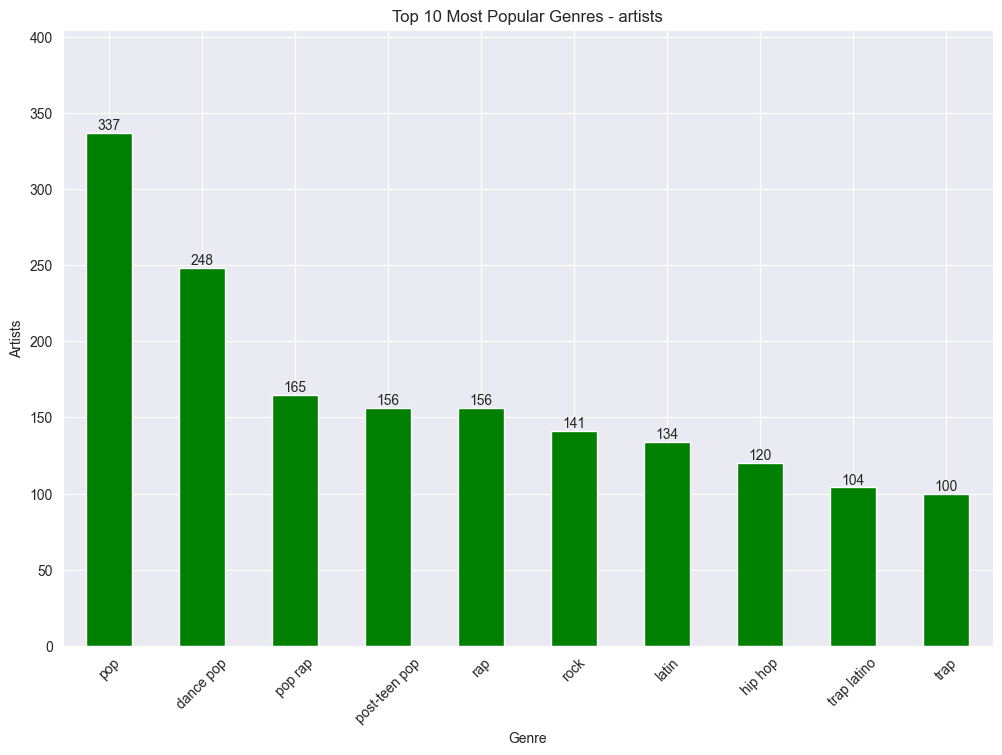

In [8]:
exploded_df = artists.explode('genres')
genre_counts = exploded_df['genres'].value_counts()

top_10_genres = genre_counts.head(10)
plt.figure(figsize=(12, 8))
top_10_genres.plot(kind='bar', color='green')
plt.title('Top 10 Most Popular Genres - artists')
plt.xlabel('Genre')
plt.ylabel('Artists')
plt.xticks(rotation=45)
plt.ylim(0, top_10_genres.max() * 1.2)
for i, count in enumerate(top_10_genres):
    plt.text(i, count + 0.2, str(count), ha='center', va='bottom')

plt.show()

Powyższy wykres przedstawia, w których gatunkach tworzy największa ilość artystów.

#### sessions.jsonl

In [9]:
sessions.isnull().sum()

session_id         0
timestamp          0
user_id            0
track_id      187681
event_type         0
dtype: int64

W zbiorze sessions również odnotowaliśmy wartości null, mianowicie braki występują w kolumnach `user_id`, `track_id` oraz `event_type`- są one znaczące (kilka tysięcy), co z pewnością wpływa na dalszą analizę tego zbioru.

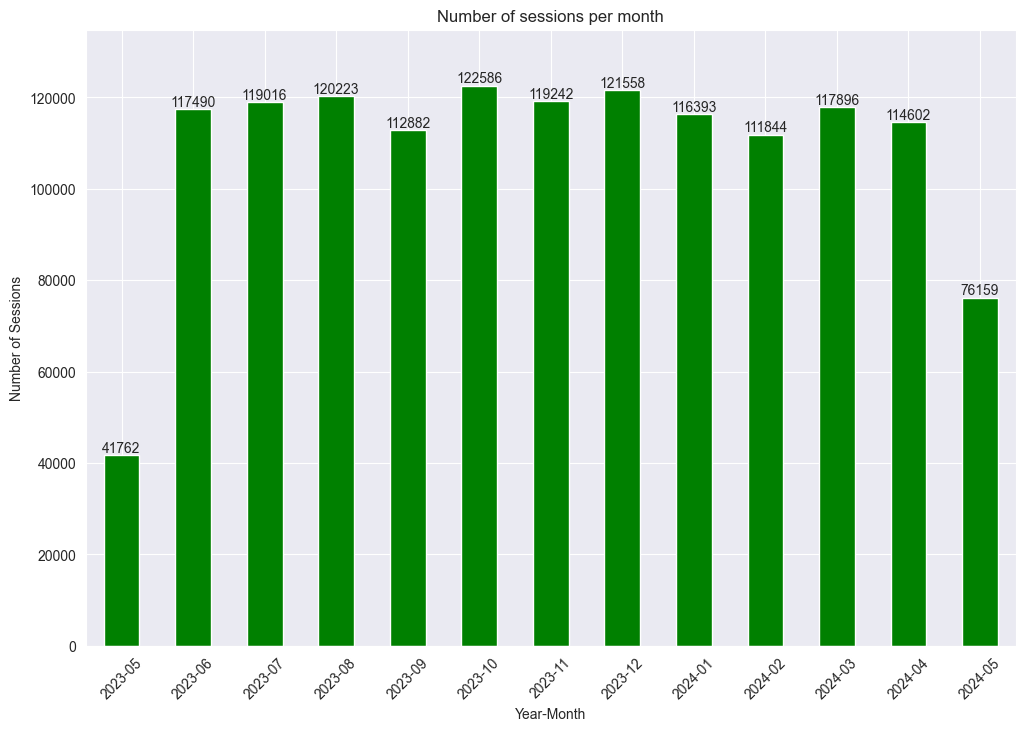

In [10]:
sessions['timestamp'] = pd.to_datetime(sessions['timestamp'])

sessions['year-month'] = sessions['timestamp'].dt.strftime('%Y-%m')
sessions_month = sessions['year-month'].value_counts().sort_index()
plt.figure(figsize=(12, 8))
sessions_month.plot(kind='bar', color='green')
plt.title('Number of sessions per month')
plt.xlabel('Year-Month')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)
plt.ylim(0, sessions_month.max() * 1.1)
for i, count in enumerate(sessions_month):
    plt.text(i, count + 0.2, str(count), ha='center', va='bottom')
plt.show()

Na podstawie powyższego wykresu, przedstawiającego ilość sesji danego miesiąca, jesteśmy w stanie stwierdzić, że jest ona porównywalna miesiąc do miesiąca, z wyjątkiem kwietnia 2024. Z tego powodu, nie uwzględnimi tego miesiąca w dalszych pracach nad projektem.

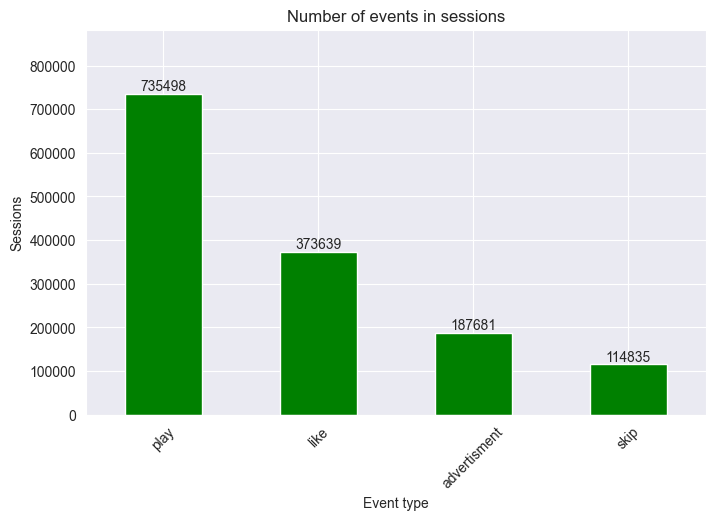

In [11]:
exploded_df = sessions.explode('event_type')
genre_counts = exploded_df['event_type'].value_counts()

top_10_genres = genre_counts.head(10)
plt.figure(figsize=(8, 5))
top_10_genres.plot(kind='bar', color='green')
plt.title('Number of events in sessions')
plt.xlabel('Event type')
plt.ylabel('Sessions')
plt.xticks(rotation=45)
plt.ylim(0, top_10_genres.max() * 1.2)
for i, count in enumerate(top_10_genres):
    plt.text(i, count + 0.2, str(count), ha='center', va='bottom')

plt.show()

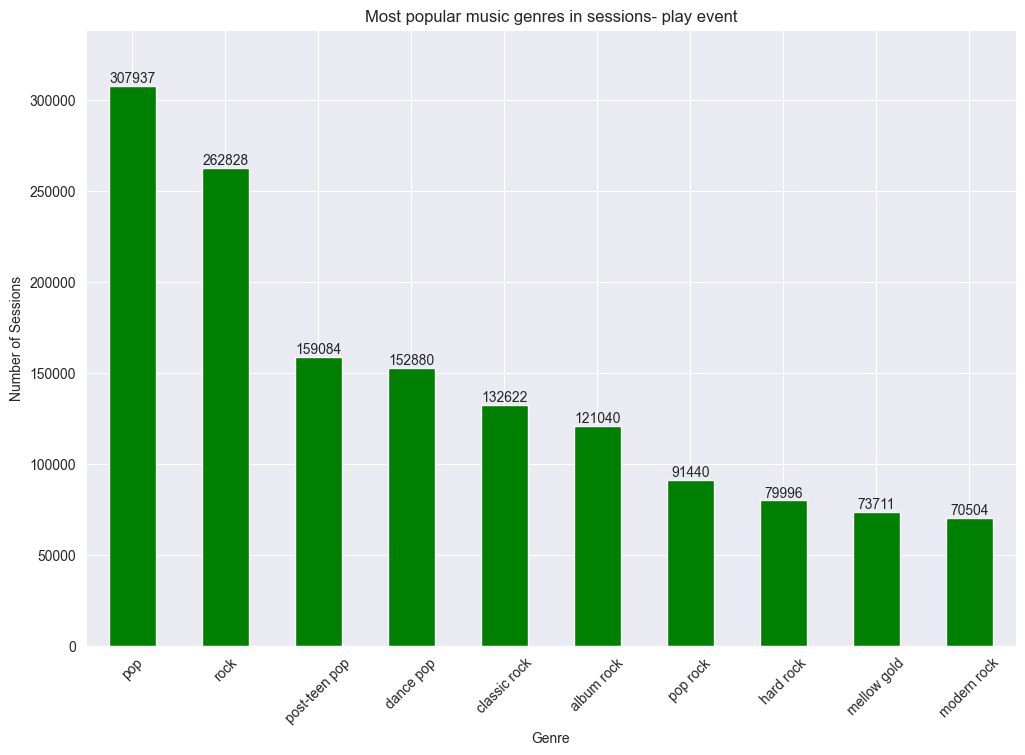

In [12]:
merged_df = pd.merge(sessions, tracks, left_on='track_id', right_on='id')
merged_df = pd.merge(merged_df, artists, left_on='id_artist', right_on='id')
merged_df = merged_df[merged_df['event_type'] == 'play']
exploded_df = merged_df.explode('genres')
genre_counts = exploded_df['genres'].value_counts()
top_10_genres = genre_counts.head(10)

plt.figure(figsize=(12, 8))
top_10_genres.plot(kind='bar', color='green')
plt.xlabel('Genre')
plt.ylabel('Number of Sessions')
plt.title('Most popular music genres in sessions- play event')
plt.xticks(rotation=45)
plt.ylim(0, top_10_genres.max() * 1.1)
for i, count in enumerate(top_10_genres):
    plt.text(i, count + 0.2, str(count), ha='center', va='bottom')
plt.show()

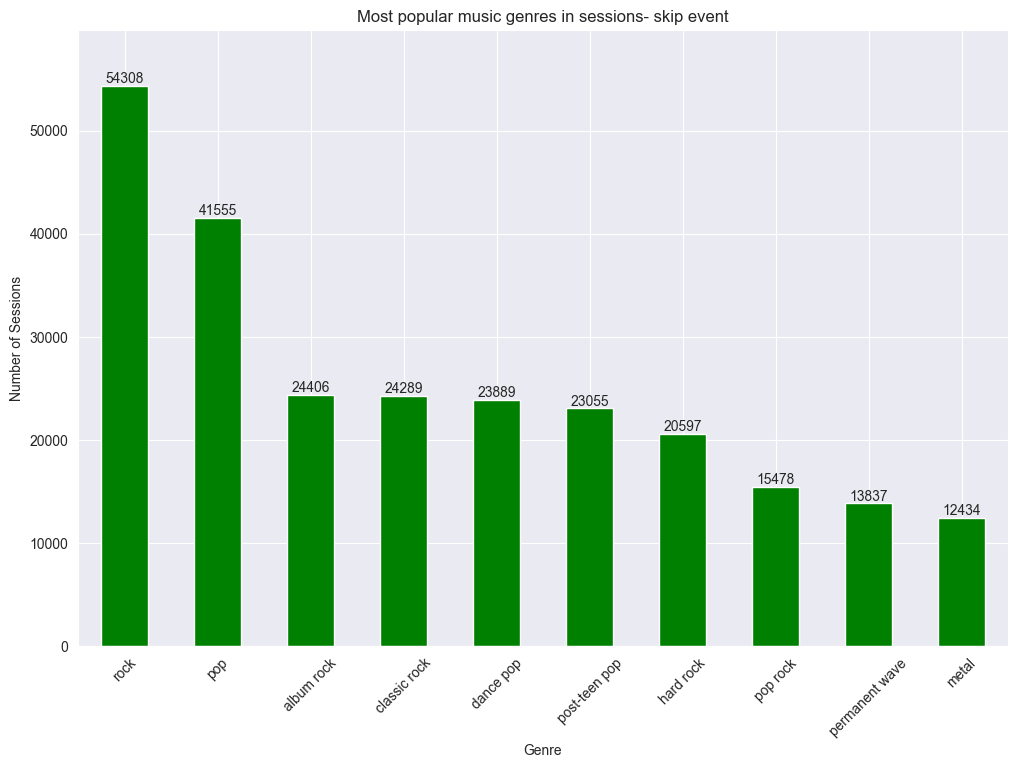

In [13]:
merged_df = pd.merge(sessions, tracks, left_on='track_id', right_on='id')
merged_df = pd.merge(merged_df, artists, left_on='id_artist', right_on='id')
merged_df = merged_df[merged_df['event_type'] == 'skip']
exploded_df = merged_df.explode('genres')
genre_counts = exploded_df['genres'].value_counts()
top_10_genres = genre_counts.head(10)
plt.figure(figsize=(12, 8))
top_10_genres.plot(kind='bar', color='green')
plt.xlabel('Genre')
plt.ylabel('Number of Sessions')
plt.title('Most popular music genres in sessions- skip event')
plt.ylim(0, top_10_genres.max() * 1.1)
for i, count in enumerate(top_10_genres):
    plt.text(i, count + 0.2, str(count), ha='center', va='bottom')
plt.xticks(rotation=45)
plt.show()

Na podstawie powyższych dwóch wykresów, jesteśmy w stanie określić 10 najpopularniejszych gatunków muzycznych.

#### track_storage.jsonl

In [14]:
track_storage.isnull().sum()

track_id         0
storage_class    0
daily_cost       0
dtype: int64

W zbiorze track_storage nie brakuje żadnych wartości.

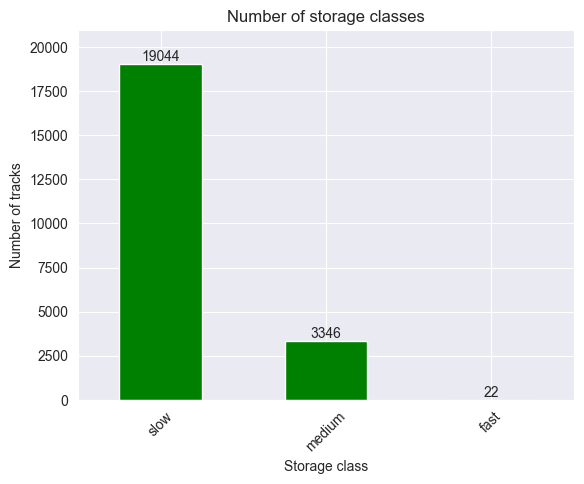

In [15]:
exploded_df = track_storage.explode('storage_class')
storage_count = exploded_df['storage_class'].value_counts()
storage_count.plot(kind='bar', color='green')
plt.xlabel('Storage class')
plt.ylabel('Number of tracks')
plt.title('Number of storage classes')
plt.ylim(0, storage_count.max() * 1.1)
for i, count in enumerate(storage_count):
    plt.text(i, count + 0.2, str(count), ha='center', va='bottom')
plt.xticks(rotation=45)
plt.show()

Po analizie problemu biznesowego stwierdziliśmy, że informacje o przechowywaniu fizycznym piosenek nie będą nam potrzebne do realizacji zadania.

#### tracks.jsonl

In [16]:
tracks.isnull().sum()

id                  0
name                0
popularity          0
duration_ms         0
explicit            0
id_artist           0
release_date        0
danceability        0
energy              0
key                 0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
dtype: int64

Zbiór tracks jest niekompletny, brakuje w nim wartości: `id`, `name`, `popularity` oraz `id_artist.

<Axes: >

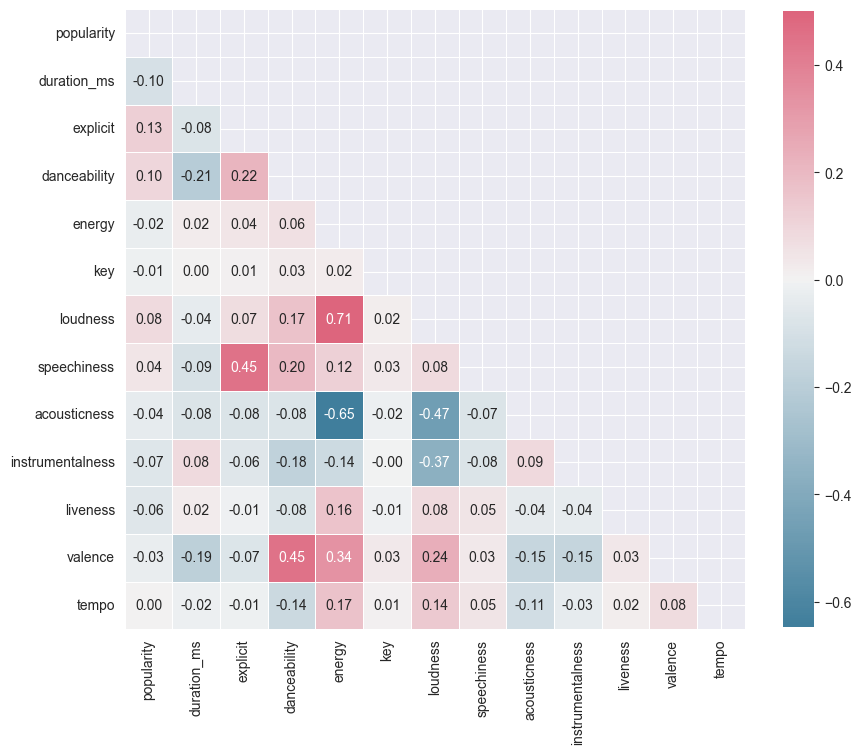

In [17]:
tracks_attributes = tracks.drop(columns=['id', 'name', 'id_artist', 'release_date'])
attributes_corr = tracks_attributes.corr()

f, ax = plt.subplots(figsize=(10, 10))

mask = np.triu(np.ones_like(attributes_corr, dtype=bool))
cmap = sns.diverging_palette(230, 5, as_cmap=True)

sns.heatmap(attributes_corr, cmap=cmap, vmax=.5, center=0, annot=True, fmt=".2f", mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.8})


Sprawdziliśmy również korelację pomiędzy atrybutami piosenek- powyższy wykres. Można zauważyć, że popularność piosenki jest skorelowana z jej cechami: `explicit`, `dancebility`, `loudness` oraz `speechiness`. Wykres sugeruje występowanie negatywnej korelacji pomiędzy zmienną `duration_ms` a `popularity`.

#### users.jsonl

In [18]:
users.isnull().sum()

user_id             0
name                0
city                0
street              0
favourite_genres    0
premium_user        0
dtype: int64

Zbiór users jest niekompletny, brakuje danych: `favourite_genres`, `premium_user` oraz `id`. Otrzymany przez nas zbiór users jest mały do prawidłowego zamodelowania.

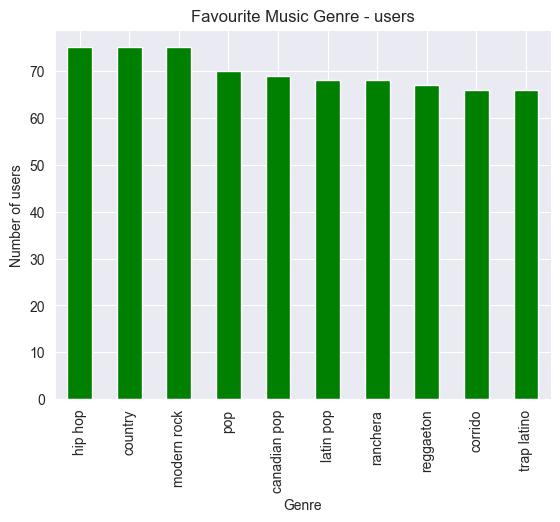

In [19]:
exploded_df = users.explode('favourite_genres')
genre_counts = exploded_df['favourite_genres'].value_counts()
top_10_genres = genre_counts.head(10)

top_10_genres.plot(kind='bar', color='green')
plt.xlabel('Genre')
plt.ylabel('Number of users')
plt.title('Favourite Music Genre - users')
plt.show()

Na podstawie wykresu jesteśmy w stanie określić ulubione gatunki muzyczne wśród użytkowników.